## 라이브러리 import

In [1]:
import os
import math
import copy
import numpy as np
import tensorflow as tf

from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize

from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

In [2]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import VGG19

In [3]:
backbones = {"vgg16": VGG16, "vgg19": VGG19}

In [4]:
DEFAULT_SKIP_CONNECTIONS = {
    'vgg16':            ('block5_conv3', 'block4_conv3', 'block3_conv3', 'block2_conv2', 'block1_conv2',
                         'block5_pool', 'block4_pool', 'block3_pool', 'block2_pool', 'block1_pool'),
    'vgg19':            ('block5_conv4', 'block4_conv4', 'block3_conv4', 'block2_conv2', 'block1_conv2',
                         'block5_pool', 'block4_pool', 'block3_pool', 'block2_pool', 'block1_pool')}

## 데이터 전처리

In [5]:
def build_augmentation(is_train=True):
    if is_train:    # 훈련용 데이터일 경우
        return Compose([
            HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
            RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                min_max_height=(300, 370),
                w2h_ratio=370/1242,
                height=224,
                width=224,
                p=0.5
            ),
            Resize(              # 입력이미지를 224X224로 resize
                width=224,
                height=224
            )
        ])
    
    return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
        Resize(
            width=224,
            height=224
        )
    ])

In [6]:
class KittiGenerator(tf.keras.utils.Sequence):
    '''
    KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
    우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
    '''
    def __init__(self, 
                 dir_path,
                 batch_size=16,
                 img_size=(224, 224, 3),
                 output_size=(224, 224),
                 is_train=True,
                 augmentation=None):
        '''
        dir_path: dataset의 directory path입니다.
        batch_size: batch_size입니다.
        img_size: preprocess에 사용할 입력이미지의 크기입니다.
        output_size: ground_truth를 만들어주기 위한 크기입니다.
        is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
        augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
        '''
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.dir_path = dir_path
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size
        
        # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
        self.data = self.load_dataset()
        
    def load_dataset(self):
        # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
        # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
        input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = [ _ for _ in zip(input_images, label_images)]
        
        if self.is_train:
            return data[:-30]
        return data[-30:]
    
    def __len__(self):
        # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
        return math.ceil(len(self.data) / self.batch_size)
    
    def __getitem__(self, index):
        # 입력과 출력을 만듭니다.
        # 입력은 resize및 augmentation이 적용된 input image이고 
        # 출력은 semantic label입니다.
        batch_data = self.data[
            index*self.batch_size:
            (index + 1)*self.batch_size
        ]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])
        
        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output==7).astype(np.uint8)*1
            data = {
                "image": _input,
                "mask": _output,
            }
            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"]/255
            outputs[i] = augmented["mask"]
        return inputs, outputs
        
    def on_epoch_end(self):
        # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
        self.indexes = np.arange(len(self.data))
        if self.is_train == True :
            np.random.shuffle(self.indexes)
            return self.indexes

In [7]:
dir_path = os.getenv('HOME')+'/aiffel/node_data/GD07/semantic_segmentation/data/training'

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

In [8]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

## 모델 구축

In [9]:
def get_backbone(name, *args, **kwargs):
    return backbones[name](*args, **kwargs)

In [10]:
def get_layer_number(model, layer_name):
    for i, l in enumerate(model.layers):
        if l.name == layer_name:
            return i
    raise ValueError('No layer with name {} in  model {}.'.format(layer_name, model.name))

In [11]:
def freeze_model(model):
    for layer in model.layers:
        layer.trainable = False
    return

In [12]:
def to_tuple(x):
    if isinstance(x, tuple):
        if len(x) == 2:
            return x
    elif np.isscalar(x):
        return (x, x)

    raise ValueError('Value should be tuple of length 2 or int value, got "{}"'.format(x))

In [13]:
def handle_block_names(stage, cols):
    conv_name = 'decoder_stage{}-{}_conv'.format(stage, cols)
    bn_name = 'decoder_stage{}-{}_bn'.format(stage, cols)
    relu_name = 'decoder_stage{}-{}_relu'.format(stage, cols)
    up_name = 'decoder_stage{}-{}_upsample'.format(stage, cols)
    merge_name = 'merge_{}-{}'.format(stage, cols)
    return conv_name, bn_name, relu_name, up_name, merge_name

In [14]:
def ConvRelu(filters, kernel_size, use_batchnorm=False, conv_name='conv', bn_name='bn', relu_name='relu'):
    def layer(x):
        x = Conv2D(filters, kernel_size, padding="same", name=conv_name, use_bias=not(use_batchnorm))(x)
        if use_batchnorm:
            x = BatchNormalization(name=bn_name)(x)
        x = Activation('relu', name=relu_name)(x)
        return x
    return layer

In [15]:
def Transpose2D_block(filters, stage, cols, kernel_size=(3,3), upsample_rate=(2,2),
                      transpose_kernel_size=(4,4), use_batchnorm=False, skip=None):
    def layer(input_tensor):
        
        conv_name, bn_name, relu_name, up_name, merge_name = handle_block_names(stage, cols)
        
        x = Conv2DTranspose(filters, transpose_kernel_size, strides=upsample_rate,
                            padding='same', name=up_name, use_bias=not(use_batchnorm))(input_tensor)
        if use_batchnorm:
            x = BatchNormalization(name=bn_name+'1')(x)
        x = Activation('relu', name=relu_name+'1')(x)
        
        if (type(skip) != list and skip is not None) or (type(skip) == list and None not in skip):
            # print("\nskip = {}".format(skip))
            if type(skip) is list:
                merge_list = []
                merge_list.append(x)
                for l in skip:
                    merge_list.append(l)
                x = Concatenate(name=merge_name)(merge_list)
            else:
                x = Concatenate(name=merge_name)([x, skip])
                
            x = ConvRelu(filters, kernel_size, use_batchnorm=use_batchnorm,
                         conv_name=conv_name + '2', bn_name=bn_name + '2', relu_name=relu_name + '2')(x)
            
        return x
    return layer

In [16]:
def build_xnet(backbone, classes, skip_connection_layers,
               decoder_filters=(256,128,64,32,16),
               upsample_rates=(2,2,2,2,2),
               n_upsample_blocks=5,
               activation='sigmoid',
               use_batchnorm=True):
    
    input = backbone.input
    
    up_block = Transpose2D_block
        
    if len(skip_connection_layers) > n_upsample_blocks:
        downsampling_layers = skip_connection_layers[int(len(skip_connection_layers)/2):]
        skip_connection_layers = skip_connection_layers[:int(len(skip_connection_layers)/2)]
    else:
        downsampling_layers = skip_connection_layers
        
    skip_connection_idx = ([get_layer_number(backbone, l) if isinstance(l, str) else l
                               for l in skip_connection_layers])
    skip_layers_list = [backbone.layers[skip_connection_idx[i]].output for i in range(len(skip_connection_idx))]
    downsampling_idx = ([get_layer_number(backbone, l) if isinstance(l, str) else l
                               for l in downsampling_layers])
    downsampling_list = [backbone.layers[downsampling_idx[i]].output for i in range(len(downsampling_idx))]
    downterm = [None] * (n_upsample_blocks+1)
    
    for i in range(len(downsampling_idx)):
        if downsampling_list[0].name == backbone.output.name:
            downterm[n_upsample_blocks-i] = downsampling_list[i]
        else:
            downterm[n_upsample_blocks-i-1] = downsampling_list[i]
    downterm[-1] = backbone.output
    
    interm = [None] * (n_upsample_blocks+1) * (n_upsample_blocks+1)
    for i in range(len(skip_connection_idx)):
        interm[-i*(n_upsample_blocks+1)+(n_upsample_blocks+1)*(n_upsample_blocks-1)] = skip_layers_list[i]
    interm[(n_upsample_blocks+1)*n_upsample_blocks] = backbone.output
    
    for j in range(n_upsample_blocks):
        for i in range(n_upsample_blocks-j):
            upsample_rate = to_tuple(upsample_rates[i])
            
            if i == 0 and j < n_upsample_blocks-1 and len(skip_connection_layers) < n_upsample_blocks:
                interm[(n_upsample_blocks+1)*i+j+1] = None
            elif j == 0:
                if downterm[i+1] is not None:
                    interm[(n_upsample_blocks+1)*i+j+1] = up_block(decoder_filters[n_upsample_blocks-i-2], 
                                      i+1, j+1, upsample_rate=upsample_rate,
                                      skip=interm[(n_upsample_blocks+1)*i+j], 
                                      use_batchnorm=use_batchnorm)(downterm[i+1])
                else:
                    interm[(n_upsample_blocks+1)*i+j+1] = None
            else:
                interm[(n_upsample_blocks+1)*i+j+1] = up_block(decoder_filters[n_upsample_blocks-i-2], 
                                  i+1, j+1, upsample_rate=upsample_rate,
                                  skip=interm[(n_upsample_blocks+1)*i : (n_upsample_blocks+1)*i+j+1], 
                                  use_batchnorm=use_batchnorm)(interm[(n_upsample_blocks+1)*(i+1)+j])
                
    x = Conv2D(classes, (3,3), padding='same', name='final_conv')(interm[n_upsample_blocks])
    x = Activation(activation, name=activation)(x)
    
    model = Model(input, x)
    
    return model

In [17]:
def Xnet(backbone_name='vgg16',
         input_shape=(None, None, 3),
         input_tensor=None,
         encoder_weights='imagenet',
         skip_connections='default',
         decoder_filters=(256,128,64,32,16),
         decoder_use_batchnorm=True,
         n_upsample_blocks=5,
         upsample_rates=(2,2,2,2,2),
         classes=1,
         activation='sigmoid'):
    
    backbone = get_backbone(backbone_name,
                            input_shape=input_shape,
                            input_tensor=input_tensor,
                            weights=encoder_weights,
                            include_top=False)
    
    if skip_connections == 'default':
        skip_connections = DEFAULT_SKIP_CONNECTIONS[backbone_name]
    
    model = build_xnet(backbone,
                       classes,
                       skip_connections,
                       decoder_filters=decoder_filters,
                       activation=activation,
                       n_upsample_blocks=n_upsample_blocks,
                       upsample_rates=upsample_rates,
                       use_batchnorm=decoder_use_batchnorm)
    
    return model

In [18]:
model = Xnet('vgg16', (224, 224, 3))

In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
______________________________________________________________________________________________

In [20]:
def dice_coef(y_true, y_pred):
    smooth = 1.0
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

In [21]:
def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dice = dice_coef(y_true, y_pred)
    return 0.5 * bce + (1 - dice)

In [22]:
def custom_loss(y_true, y_pred):
    loss = bce_dice_loss(y_true, y_pred)  # y_true is the same for all channels
    
    return loss

In [23]:
model_path = os.getenv('HOME')+'/aiffel/model_weight/GD07/vgg16_unet++3.h5'

model.compile(optimizer = Adam(1e-4), loss = custom_loss)

history = model.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model.save(model_path)

Epoch 1/100
11/11 [==============================] - 42s 1s/step - loss: 0.8257 - val_loss: 1.5659
Epoch 2/100
11/11 [==============================] - 15s 1s/step - loss: 0.6408 - val_loss: 1.5933
Epoch 3/100
11/11 [==============================] - 15s 1s/step - loss: 0.5184 - val_loss: 1.4689
Epoch 4/100
11/11 [==============================] - 14s 1s/step - loss: 0.4220 - val_loss: 1.4174
Epoch 5/100
11/11 [==============================] - 14s 1s/step - loss: 0.3913 - val_loss: 1.3137
Epoch 6/100
11/11 [==============================] - 14s 1s/step - loss: 0.3884 - val_loss: 0.6114
Epoch 7/100
11/11 [==============================] - 14s 1s/step - loss: 0.3663 - val_loss: 0.6356
Epoch 8/100
11/11 [==============================] - 14s 1s/step - loss: 0.3058 - val_loss: 0.3998
Epoch 9/100
11/11 [==============================] - 14s 1s/step - loss: 0.2860 - val_loss: 0.3312
Epoch 10/100
11/11 [==============================] - 14s 1s/step - loss: 0.2869 - val_loss: 0.5456
Epoch 11/

11/11 [==============================] - 14s 1s/step - loss: 0.1477 - val_loss: 0.1500
Epoch 84/100
11/11 [==============================] - 14s 1s/step - loss: 0.1541 - val_loss: 0.1867
Epoch 85/100
11/11 [==============================] - 14s 1s/step - loss: 0.1194 - val_loss: 0.1267
Epoch 86/100
11/11 [==============================] - 14s 1s/step - loss: 0.1007 - val_loss: 0.1409
Epoch 87/100
11/11 [==============================] - 14s 1s/step - loss: 0.1011 - val_loss: 0.2092
Epoch 88/100
11/11 [==============================] - 14s 1s/step - loss: 0.1088 - val_loss: 0.1112
Epoch 89/100
11/11 [==============================] - 14s 1s/step - loss: 0.1219 - val_loss: 0.1270
Epoch 90/100
11/11 [==============================] - 14s 1s/step - loss: 0.1028 - val_loss: 0.1362
Epoch 91/100
11/11 [==============================] - 14s 1s/step - loss: 0.0900 - val_loss: 0.1201
Epoch 92/100
11/11 [==============================] - 14s 1s/step - loss: 0.0897 - val_loss: 0.1341
Epoch 93/100


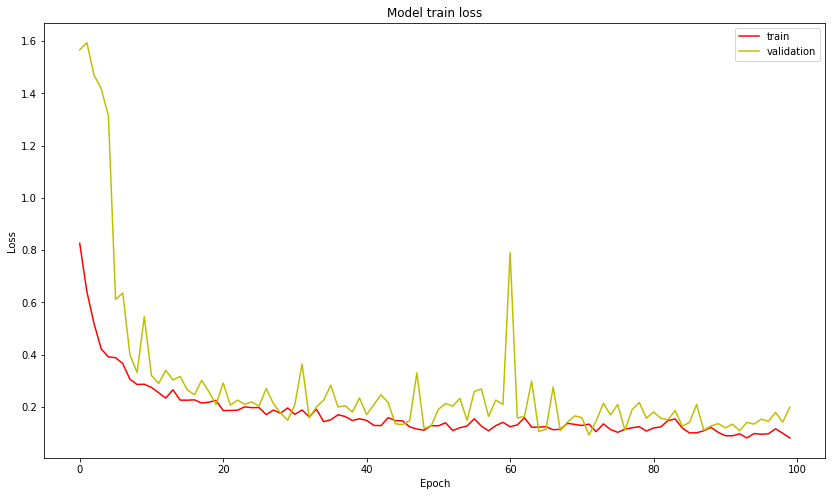

In [24]:
plt.figure(figsize=(14, 8))

plt.plot(history.history['loss'], 'r')
plt.plot(history.history['val_loss'], 'y')
plt.title('Model train loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

## 모델 시각화

In [25]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction).sum()
    union = np.logical_or(target, prediction).sum()
    iou_score = float(intersection) / float(union) if union != 0 else 0.0
    print('IoU : %f' % iou_score )
    return iou_score

In [26]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

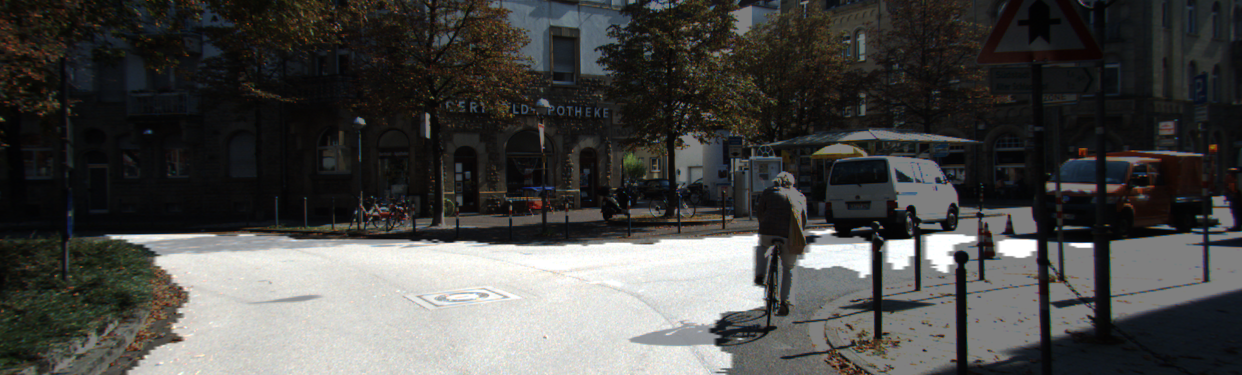

IoU : 0.801388


0.8013883880274072

In [27]:
i = 3
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

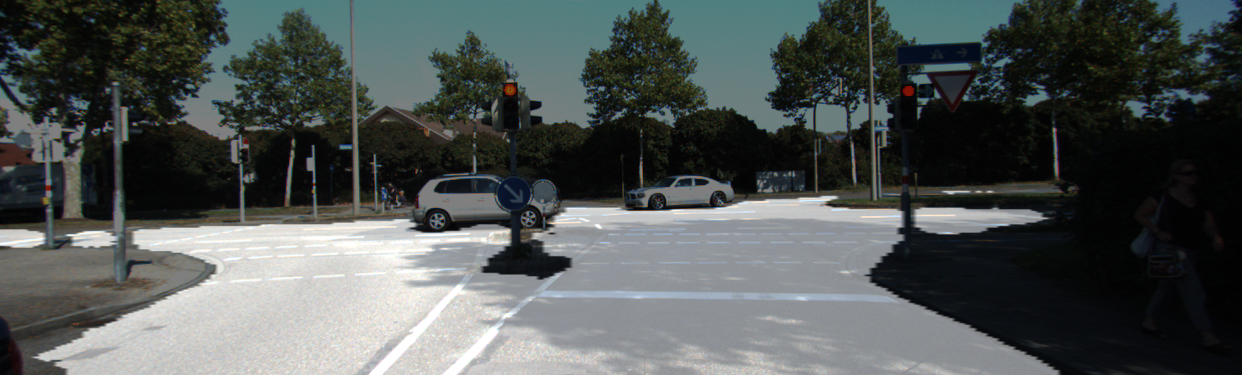

IoU : 0.925428


0.9254277041942605

In [28]:
i = 9
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)